<center><h2>Machine Learning Process in SparkML: Hyper Parameter Tuning</h2></center>

# 1. Data Ingestion and Preprocessing

Given the pipeline we created in the previous lecture, it is now pretty straghtforward to conduct data ingestion and preprocessing. We will again load a training dataset and a test dataset process it with our pipeline. 


In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0)
        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [2]:
# if you installed Spark on windows, 
# you may need findspark and need to initialize it prior to being able to use pyspark
# Also, you may need to initialize SparkContext yourself.
# Uncomment the following lines if you are using Windows!
#import findspark
#findspark.init()
#findspark.find()

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('./NSL-KDD/KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('./NSL-KDD/KDDTest+.txt',header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)


nslkdd_df.cache()
nslkdd_df_test.cache()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/06 10:14:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/06 10:14:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[features: vector, outcome: double]

# 2. Cross Validation for Logistic Regression

Let's start with where we left off last lecture. Let's first train the logistic regression model, plot its ROC curve, and calculate its area under curve. 


23/10/06 10:15:00 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


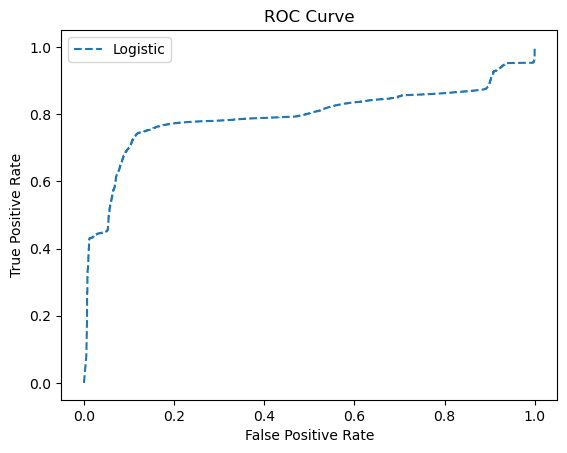

Area under the curve is:  0.7938137611396217


In [3]:
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import roc_curve
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy
from matplotlib import pyplot as plt

lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')

lr_model = lr.fit(nslkdd_df) # fit the logistic regression model to the training dataset

lr_predictions = lr_model.transform(nslkdd_df_test) # make predictions
outcome_true = lr_predictions.select('outcome').toPandas() # the true outcome label as Pandas df


# make the ROC curve
lr_pred_prob = lr_predictions.select("probability")
to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
lr_pred_prob = lr_pred_prob.withColumn('probability', to_array('probability'))
lr_pred_prob = lr_pred_prob.toPandas()
lr_pred_prob_nparray = np.array(lr_pred_prob['probability'].values.tolist())

lr_fpr, lr_tpr, lr_thresholds = roc_curve(outcome_true, lr_pred_prob_nparray[:,1])

plt.plot(lr_fpr, lr_tpr, linestyle='--', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# calculate the area under curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
    labelCol='outcome', metricName='areaUnderROC')

print("Area under the curve is: ", evaluator.evaluate(lr_predictions))


Based on the computed area under the curve (AUC), our question in this section is how do we improve the AUC. 

When we created the `LogisticRegression` estimator, we didn't specify anything other than the name of the features and the label column. In reality, it accepts a range of other optional arguments:

```python 
class pyspark.ml.classification.LogisticRegression(*, featuresCol: str = 'features', labelCol: str = 'label', predictionCol: str = 'prediction', maxIter: int = 100, regParam: float = 0.0, elasticNetParam: float = 0.0, tol: float = 1e-06, fitIntercept: bool = True, threshold: float = 0.5, thresholds: Optional[List[float]] = None, probabilityCol: str = 'probability', rawPredictionCol: str = 'rawPrediction', standardization: bool = True, weightCol: Optional[str] = None, aggregationDepth: int = 2, family: str = 'auto', lowerBoundsOnCoefficients: Optional[pyspark.ml.linalg.Matrix] = None, upperBoundsOnCoefficients: Optional[pyspark.ml.linalg.Matrix] = None, lowerBoundsOnIntercepts: Optional[pyspark.ml.linalg.Vector] = None, upperBoundsOnIntercepts: Optional[pyspark.ml.linalg.Vector] = None, maxBlockSizeInMB: float = 0.0)
```

Some of the arguments, like `rawPredictionCol`, allows us to change the name of the scores output column to something other than the default `'rawPrediction'`. 

Other arguments, including `maxIter,regParam, elasticNetParam`, actually control the fitting (training) behavior and may impact the performance of the fitted model. These arguments are called **Hyper-Parameters** and the goal of cross validation is to change the hyper-parameters with the goal of **finding a combination of hyper-parameters that produce a fitted model with the best performance**, where the performance metric we use today is AUC.   

One powerful method to tune the hyper-parameters is to use cross-validation. Overall, the tuning process will try each of the hyper-parameters and evaluate the AUC of the trained model with that particular hyper-parameter. Then, we pick the hyper-parameter with the highest AUC and return the model trained with this hyper-parameter. Note that in this process, we shouldn't use the test set to evaluate the AUC. Instead, we should use k-fold cross-validation. For more details, please see the lecture slides. 

Parameter tuning with cross-validation can be easily implemented in SparkML using `CrossValidator`, shown in the code below. 



In [4]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')

# Create ParamGrid for Cross Validation
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
    labelCol='outcome', metricName='areaUnderROC')

lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, 
                    evaluator=evaluator, numFolds=5)



The `CrossValidator` is actually an Estimator object and we can fit it to the training dataset. The resulting object will be a fitted logistic regression model (a Transformer) trained with the best hyper-parameter. 

In [5]:
lr_cv_model = lr_cv.fit(nslkdd_df)

Let's use the tuned model to make predictions and calculate its AUC on the test data set. We will also plot its ROC curve and compare with the ROC curve before tuning. 

In [6]:
lr_cv_prediction_test = lr_cv_model.transform(nslkdd_df_test)
print('Test Area Under ROC (AUC) after Cross-Validation:', evaluator.evaluate(lr_cv_prediction_test))
print('Test Area Under ROC (AUC) before Cross-Validation:', evaluator.evaluate(lr_predictions))

Test Area Under ROC (AUC) after Cross-Validation: 0.8674445547867702
Test Area Under ROC (AUC) before Cross-Validation: 0.7938137611396217


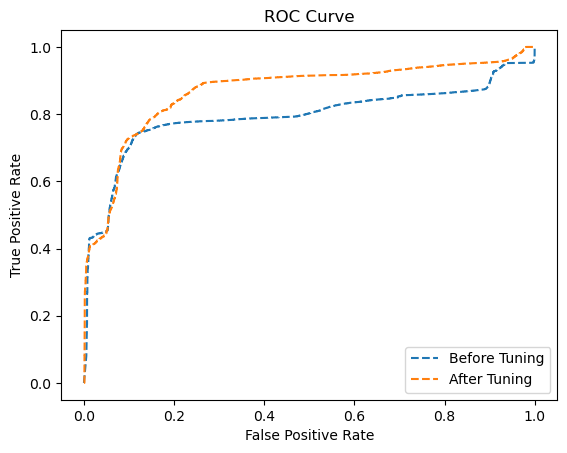

23/10/06 13:12:01 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 894030 ms exceeds timeout 120000 ms
23/10/06 13:12:01 WARN SparkContext: Killing executors is not supported by current scheduler.
23/10/06 13:12:01 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [7]:
lr_cv_pred_prob = (lr_cv_prediction_test.select("probability").
        withColumn('probability', to_array('probability')).toPandas())
lr_cv_pred_prob = np.array(lr_cv_pred_prob['probability'].values.tolist())

lr_cv_fpr, lr_cv_tpr, lr_cv_thresholds = roc_curve(outcome_true, lr_cv_pred_prob[:,1])
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, linestyle='--', label='Before Tuning')
plt.plot(lr_cv_fpr, lr_cv_tpr, linestyle='--', label='After Tuning')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# show the legend
plt.legend()
# show the plot
plt.show()